# Introduction

## Face Recognition with TensorFlow

In this notebook, we'll develop a face recognition model using TensorFlow. The model will be capable of predicting the identity of a person based on an input image. We will utilize transfer learning and pretrained models to enhance the performance of our model.

### Objective

Our goal is to build a face recognition model that can accurately identify individuals from input images.

### Dataset

We'll be using the datasettaken from kaggle, which contains labeled images of faces from various celebrities.

### Tools and Libraries

We'll be using TensorFlow for building and training the model, along with other libraries such as NumPy, OpenCV, and scikit-learn for data processing and manipulation.


### Lets Break Down the Task

* Import the necessary Dataset that will be used for training and testing

* Split the Dataset into training and testing datasets

* Import a pre-trained model to enhance the performance of the model.For this project we shall use ResNet50 

* Resizing the images in the dataset for optimal performance from the pre-trained model

* Compile the model with the specified loss function, optimizer, and evaluation metrics.

* Create an Image Data Generator object for the training and testing data with data augmentation.

* Define Training and Testing Sets

## Data Visualization


* Plotting Accuracy of the Model

* Prediction on Test Set

* Calculating Precision, Recall and F1 Score

* Plotting Accuracy, Precision, Recall and F1 Score


### Install Python Package to Split folders with files into train, validation and test (dataset) folders 

In [1]:
!pip install split-folders -qqq

## Import Necessary Libraries

We start by importing the necessary libraries for our project, including TensorFlow, NumPy, OpenCV, and others.

In [2]:
import os
import warnings
import splitfolders

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

warnings.simplefilter('ignore')
pd.options.display.float_format = '{:.2f}'.format

tf.__version__ 

2024-06-04 19:19:02.503022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 19:19:02.503147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 19:19:02.618216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

In [3]:
!mkdir face-recognition-dataset

for celeb in ['Hrithik Roshan', 'Henry Cavill', 'Robert Downey Jr']:
    os.system(f'cp -r "/kaggle/input/face-recognition-dataset/Original Images/Original Images/{celeb}" "face-recognition-dataset/{celeb}"')

In [4]:
!ls face-recognition-dataset

'Henry Cavill'	'Hrithik Roshan'  'Robert Downey Jr'


In [5]:
splitfolders.ratio("face-recognition-dataset", output="face-recognition-dataset-splitted", seed=1, ratio=(.8, .2))

Copying files: 320 files [00:00, 2952.11 files/s]


In [6]:
!ls face-recognition-dataset-splitted

train  val


### Training and Testing Paths
Here, we define the path of the dataset for training and validation sets.

In [7]:
train_path = 'face-recognition-dataset-splitted/train'
val_path = 'face-recognition-dataset-splitted/val'

folders = glob(train_path + '/*')
len(folders)

3

In [8]:
assert list(set(os.listdir('face-recognition-dataset-splitted/train'))) == list(set(os.listdir('face-recognition-dataset-splitted/val')))

### Using a Pre-Trained Model and Resizing the image
We use a pretrained model to enhance our models performance and we resize the image for optimal size for the pre-trained model.

In [9]:
# Reset Image size
IMAGE_SIZE = [224, 224] 

# Load Pre-Trained Model
resnet = ResNet50(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet', #Default
    include_top = False  
)

# Using default weights used by imagenet
for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Flatten the output of the ResNet model to convert the 2D feature maps to 1D feature vectors.
x = Flatten()(resnet.output)

# The 'softmax' activation function is used to produce a probability distribution over the classes.
prediction = Dense(len(folders), activation='softmax')(x)

# The model takes the input from the ResNet model and outputs the predictions from the dense layer.
model = Model(inputs=resnet.input, outputs=prediction)

# Print a summary of the model architecture.
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,888,771 (91.13 MB)

 Trainable params: 301,059 (1.15 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Compile the model with the specified loss function, optimizer, and evaluation metrics.

Model Compilation (model.compile):

* **Loss = Categorical Crossentropy :**
1. This is the loss function used for multi-class classification tasks. It measures the performance of the model by comparing the predicted class probabilities with the true class labels.
* **Optimizer = Adam:**
1. The Adam optimizer is used to update the model's weights during training. It combines the advantages of two other popular optimizers: AdaGrad and RMSProp.
* **Metrics = 'accuracy':**
1. Accuracy is used as a metric to evaluate the performance of the model during training and testing. It measures the percentage of correct predictions.

In [11]:
model.compile(
    loss='categorical_crossentropy',  # Loss function used for multi-class classification tasks
    optimizer='adam',                # Optimizer that adjusts the weights of the neural network
    metrics=['accuracy']            
)

### Create an Image Data Generator object for the training and testing data with data augmentation.

Data augmentation techniques (like shear, zoom, and flip) are used to artificially expand the size of the training dataset by creating modified versions of the images. This helps prevent overfitting and improves the model’s ability to generalize to new, unseen data.

In [12]:
"""
-Rescale pixel values to be between 0 and 1 (normalization)
-Apply random shearing transformations to the images
-Apply random zoom transformations to the images
-Randomly flip images horizontally
"""

train_gen = ImageDataGenerator(
    rescale=1./255,              
    shear_range=0.2,           
    zoom_range=0.2,              
    horizontal_flip=True         
)

val_gen = ImageDataGenerator(
    rescale=1./255               # Rescale pixel values to be between 0 and 1 (normalization)
)

### Defining Training and Testing Sets

In [13]:
training_set = train_gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical' 
)

val_set = val_gen.flow_from_directory(
    val_path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False,
)

Found 254 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


### Training the Model

In [14]:
history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=50
)


Epoch 1/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 2:03 18s/step - accuracy: 0.4000 - loss: 1.4332

I0000 00:00:1717528781.723272      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4040 - loss: 5.4205 - val_accuracy: 0.3485 - val_loss: 3.3849
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.3489 - loss: 2.6744 - val_accuracy: 0.3788 - val_loss: 2.2983
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.4031 - loss: 1.8270 - val_accuracy: 0.4545 - val_loss: 1.7712
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.4697 - loss: 1.4367 - val_accuracy: 0.4091 - val_loss: 1.4189
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.5240 - loss: 1.0529 - val_accuracy: 0.4242 - val_loss: 1.2026
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.5008 - loss: 1.0389 - val_accuracy: 0.4242 - val_loss: 1.3341
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.4853 - loss: 0.9876 - val_accuracy: 0.3939 - val_loss: 1.3366
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.5406 - loss: 0.9474 - val_accuracy: 0.5000 - val_loss: 1.2618
Epoch

In [15]:
model.save('model.h5')

### Data Visualization

Plotting training and validation losses is a fundamental practice monitoring model performance and detecting overfitting or underfitting. By visualizing these metrics, you can make informed decisions about adjusting model complexity, regularization techniques, or early stopping criteria to improve model performance.

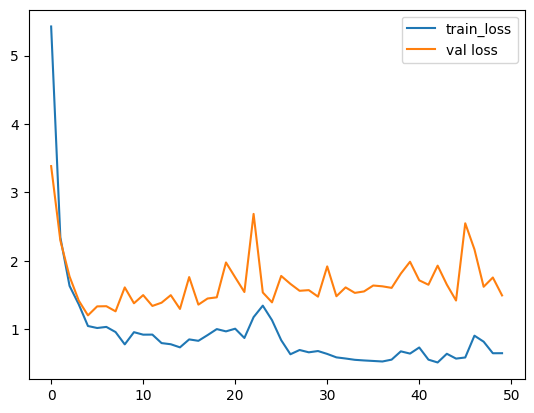

In [16]:
# Plotting the training loss
plt.plot(history.history['loss'], label='train_loss')

# Plotting the validation loss
plt.plot(history.history['val_loss'], label='val loss')

# Adding a legend to distinguish between the training and validation loss plots
plt.legend()

# Displaying the plot
plt.show()

### Plotting Accurancy of the Model
Plotting the accuracy of a model is a fundamental practice for evaluating its performance, optimizing its parameters, and ensuring that it generalizes well to unseen data. It serves as a critical tool for data scientists and machine learning practitioners to refine their models and achieve the most accurate and reliable results possible.

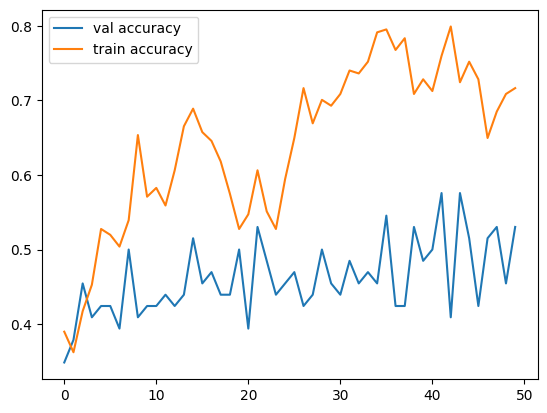

In [17]:
# Plot the Accuracy
plt.plot(history.history['val_accuracy'], label ='val accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend()
plt.show()

### Prediction on test set

In [18]:
prediction = model.predict(val_set)
prediction = np.argmax(prediction, axis = 1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [19]:
true_classes = val_set.classes

In [20]:
accuracy = accuracy_score(true_classes, prediction)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 53.03%


In [21]:
class_labels = list(val_set.class_indices.keys())
report = classification_report(true_classes, prediction, target_names = class_labels, output_dict = True)

report_df = pd.DataFrame(report).transpose()

report_df

,precision,recall,f1-score,support
Henry Cavill,0.50,0.32,0.39,22.00
Hrithik Roshan,0.52,0.52,0.52,21.00
Robert Downey Jr,0.55,0.74,0.63,23.00
accuracy,0.53,0.53,0.53,0.53
macro avg,0.52,0.53,0.51,66.00
weighted avg,0.52,0.53,0.52,66.00


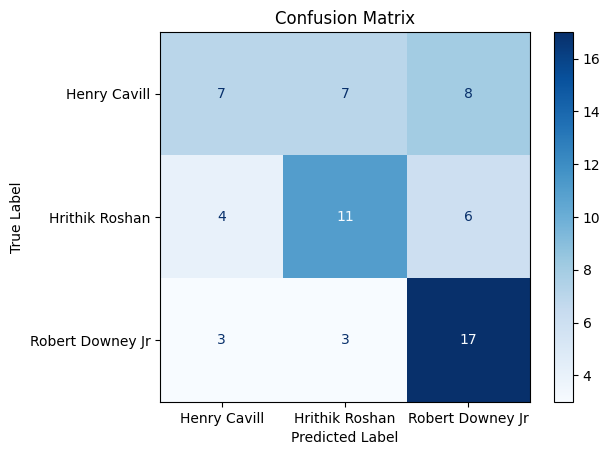

In [22]:
conf_matrix = confusion_matrix(true_classes, prediction)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = class_labels)

cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

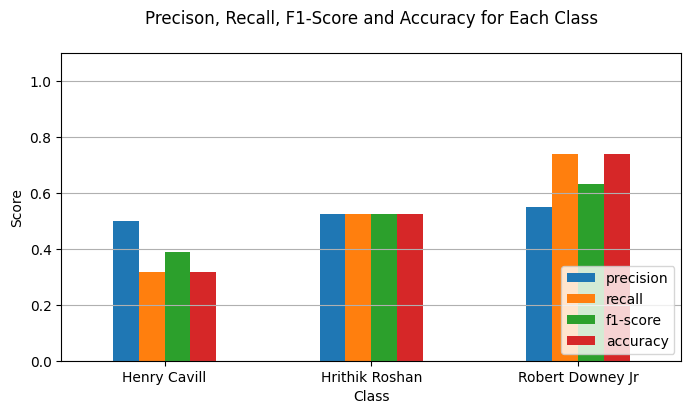

In [23]:
#Plot Precision, Recall and Precision Score
metrics_data = report_df.loc[class_labels, ['precision', 'recall', 'f1-score']]
accuracies = []

for label in class_labels:
    idx = val_set.class_indices[label]
    tp = conf_matrix[idx, idx]
    total = np.sum(conf_matrix[idx, :])
    accuracies.append(tp/total)
    
metrics_data['accuracy'] = accuracies

metrics_data.plot(kind='bar', figsize = (8, 4))

plt.title('Precison, Recall, F1-Score and Accuracy for Each Class\n')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0,1.1)
plt.legend(loc = 'lower right')
plt.xticks(rotation = 0)
plt.grid(axis = 'y')
plt.show()

# Summary and Explanation of Results

The bar chart provides a visual representation of the performance metrics—precision, recall, F1-score, and accuracy—for each class in the face recognition task. The classes shown are "Henry Cavill," "Hrithik Roshan," and "Robert Downey Jr."

## Key Observations
- **Robert Downey Jr**: The model performs well with high scores across all metrics, indicating effective recognition of this class.
- **Henry Cavill and Hrithik Roshan**: Both classes have lower scores in all metrics compared to "Robert Downey Jr." This suggests the model struggles to correctly identify these classes.

## Performance Metrics
- **Precision**: Measures the accuracy of the positive predictions. Higher for "Robert Downey Jr," indicating fewer false positives for this class.
- **Recall**: Measures the ability to find all relevant instances. Again, higher for "Robert Downey Jr," showing fewer missed identifications.
- **F1-Score**: The harmonic mean of precision and recall. Higher for "Robert Downey Jr," reflecting a balanced and effective performance.
- **Accuracy**: The overall correctness of the model's predictions. Higher for "Robert Downey Jr," indicating more reliable identification.

## Interpretation
- The model is most effective at identifying "Robert Downey Jr," but struggles with "Henry Cavill" and "Hrithik Roshan."
- The lower performance for "Henry Cavill" and "Hrithik Roshan" suggests a need for more data, better data quality, or additional model tuning for these classes.